<a href="https://colab.research.google.com/github/Rachhh53/OnMart-Kafka-Neo4j-442/blob/main/Tutorial_TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install plotly 
!pip install pystan==2.19.1.1 
!pip install prophet 
!pip install statsmodels
!pip install tensorflow
!pip install pmdarima 

     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6642397 sha256=2f7dcf363ca963a0f3cb98e33d261863d46d1f00158a9266cc387347cf640c3b
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
     |████████████████████████████████| 462 kB 15.4 MB/s 
     |████████████████████████████████| 1.4 MB 22.6

In [3]:
import pandas as pd

import datetime
from datetime import datetime, date, timedelta
import time
from math import isnan
import numpy as np

import plotly
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

import pystan
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima
from pmdarima.arima.utils import ndiffs


import tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.python.util.deprecation as deprecation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings

deprecation._PRINT_DEPRECATION_WARNINGS = False
warnings.filterwarnings('ignore')

In [4]:
from platform import python_version
print('python version installed     :', python_version(),'    ,needed: 3.7.7')
print('pmdarima version installed   :', pmdarima.__version__,'    ,needed: 1.8.0')
print('tensorflow version installed :', tensorflow.__version__,'    ,needed: 2.4.1')
print('statsmodel version installed :', statsmodels.__version__,'   ,needed: 0.11.1')
print('prophet version installed    :', prophet.__version__,'      ,needed: 1.0')
print('pystan version installed     :', pystan.__version__,' ,needed: 2.19.1.1') 
print('plotly version installed     :', plotly.__version__,'   ,needed: 4.14.3')
print('matplotlib version installed :', matplotlib.__version__,'    ,needed: 3.2.2')

python version installed     : 3.7.13     ,needed: 3.7.7
pmdarima version installed   : 1.8.5     ,needed: 1.8.0
tensorflow version installed : 2.8.0     ,needed: 2.4.1
statsmodel version installed : 0.13.2    ,needed: 0.11.1
prophet version installed    : 1.0       ,needed: 1.0
pystan version installed     : 2.19.1.1  ,needed: 2.19.1.1
plotly version installed     : 5.5.0    ,needed: 4.14.3
matplotlib version installed : 3.2.2     ,needed: 3.2.2


In [5]:
import numpy
print(numpy.__version__)

1.21.6



# Load and Preprocess the data

    Count how many total deliveries
    Count how many deliveries per Zip Code
    Total number of Orders
    Total number of Orders per Zip Code
    Total Number of Products ordered per Zip Code
    Total Number of Orders for every Product in every Zip Code per Month



In [6]:
df = pd.read_csv('Transactions.csv')
df = df.dropna()
df['Delivery_Zip_Code'] = df['Delivery_Zip_Code'].astype(int)
df.head()

,CustomerID,FirstName,LastName,CreditCardNumber,OrderID,Customer_Occupation,Credit_Card_Number,Order_ID,Order_Date,Expected_Delivery_Date,...,Product_Name,Category,Manufacturer,Review_Rating,Delivery_Tracking_ID,Delivery_Type,Delivery_Zip_Code,Transaction_Status,Order_Returned,Order_Delivered_on_Time
0,566-26-0321,Rebeka,Stokes,xxxx-xxxx-xxxx-2650,50787284-d78d-4b6a-b93f-7419b0d46590,Lawyer,12345789032,98,4/7/2020,4/11/2020,...,Fitbit small,fitness,Fitbit small,3,98,Pickup,10048,Disputed,1,1
1,274-18-0017,Rahsaan,Koch,xxxx-xxxx-xxxx-5055,f61639d7-28de-4507-a63a-71e99921d8f9,Lawyer,12345789032,131,5/10/2020,5/14/2020,...,Fitbit small,fitness,Fitbit small,3,131,Pickup,10048,Disputed,1,1
2,455-28-7950,Zion,Osinski,xxxx-xxxx-xxxx-0150,7b1caf69-bd5b-441c-9115-6fa31ba1c313,Lawyer,12345789032,318,11/13/2020,11/17/2020,...,Fitbit small,fitness,Fitbit small,3,318,Pickup,10048,Disputed,1,1
3,254-72-5938,Ward,Brekke,xxxx-xxxx-xxxx-5280,cb58e8e9-572b-4d9e-af9f-dbecf9dfd3c5,Actor,12345789032,528,2/12/2020,2/16/2020,...,Fitbit large,fitness,Fitbit large,5,528,Pickup,10048,Disputed,0,1
4,563-47-8401,Terrence,Franecki,xxxx-xxxx-xxxx-1019,a9d66460-a48f-419f-8d39-7818290a3041,Actor,12345789032,561,2/12/2020,2/16/2020,...,Fitbit large,fitness,Fitbit large,5,561,Pickup,10048,Disputed,0,1


In [7]:
df['Order_ID'].count()

16372

In [8]:
df['Expected_Delivery_Date'] = pd.to_datetime(df['Expected_Delivery_Date'])
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Actual_Delivery_Date'] = pd.to_datetime(df['Actual_Delivery_Date'])
df.set_index('Actual_Delivery_Date', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['week_of_year'] = df.index.weekofyear

In [9]:
df.dtypes

CustomerID                         object
FirstName                          object
LastName                           object
CreditCardNumber                   object
OrderID                            object
Customer_Occupation                object
Credit_Card_Number                  int64
Order_ID                            int64
Order_Date                 datetime64[ns]
Expected_Delivery_Date     datetime64[ns]
Product_ID                         object
Product_Name                       object
Category                           object
Manufacturer                       object
Review_Rating                       int64
Delivery_Tracking_ID                int64
Delivery_Type                      object
Delivery_Zip_Code                   int64
Transaction_Status                 object
Order_Returned                      int64
Order_Delivered_on_Time             int64
year                                int64
month                               int64
day                               

In [10]:
df.head()

,CustomerID,FirstName,LastName,CreditCardNumber,OrderID,Customer_Occupation,Credit_Card_Number,Order_ID,Order_Date,Expected_Delivery_Date,...,Delivery_Tracking_ID,Delivery_Type,Delivery_Zip_Code,Transaction_Status,Order_Returned,Order_Delivered_on_Time,year,month,day,week_of_year
Actual_Delivery_Date,,,,,,,,,,,,,,,,,,,,,
2020-04-15,566-26-0321,Rebeka,Stokes,xxxx-xxxx-xxxx-2650,50787284-d78d-4b6a-b93f-7419b0d46590,Lawyer,12345789032,98,2020-04-07,2020-04-11,...,98,Pickup,10048,Disputed,1,1,2020,4,15,16
2020-05-18,274-18-0017,Rahsaan,Koch,xxxx-xxxx-xxxx-5055,f61639d7-28de-4507-a63a-71e99921d8f9,Lawyer,12345789032,131,2020-05-10,2020-05-14,...,131,Pickup,10048,Disputed,1,1,2020,5,18,21
2020-11-21,455-28-7950,Zion,Osinski,xxxx-xxxx-xxxx-0150,7b1caf69-bd5b-441c-9115-6fa31ba1c313,Lawyer,12345789032,318,2020-11-13,2020-11-17,...,318,Pickup,10048,Disputed,1,1,2020,11,21,47
2020-02-20,254-72-5938,Ward,Brekke,xxxx-xxxx-xxxx-5280,cb58e8e9-572b-4d9e-af9f-dbecf9dfd3c5,Actor,12345789032,528,2020-02-12,2020-02-16,...,528,Pickup,10048,Disputed,0,1,2020,2,20,8
2020-02-20,563-47-8401,Terrence,Franecki,xxxx-xxxx-xxxx-1019,a9d66460-a48f-419f-8d39-7818290a3041,Actor,12345789032,561,2020-02-12,2020-02-16,...,561,Pickup,10048,Disputed,0,1,2020,2,20,8



<div class="alert alert-info">

  
    
# Descriptive Analytics


</div>

In [11]:
df.groupby(['Product_Name'])['Expected_Delivery_Date'].count().reset_index(name ='Total_orders_per_product')

,Product_Name,Total_orders_per_product
0,Bose,910
1,Fitbit large,2903
2,Fitbit small,2904
3,Harman Kardon,1445
4,JBL,910
5,Logitech,1525
6,Redmi,910
7,Samsung s10,910
8,Sony,2435
9,VR7,1520


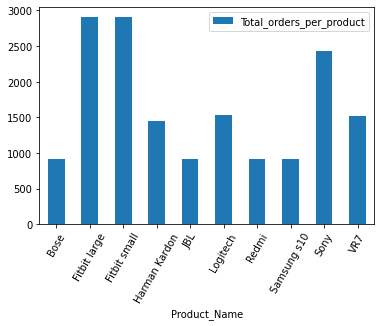

In [12]:
ax = df.groupby(['Product_Name'])['Expected_Delivery_Date'].count().reset_index(name ='Total_orders_per_product').plot.bar(x='Product_Name', y='Total_orders_per_product', rot=60)


## Deliveries/Orders per  Zip Code Distribution

In [13]:
df.groupby(['Delivery_Zip_Code'])['Expected_Delivery_Date'].count().reset_index(name ='Total_orders_per_zipcode')

,Delivery_Zip_Code,Total_orders_per_zipcode
0,10048,413
1,10110,394
2,10121,391
3,10123,439
4,10168,416
...,...,...
57,90076,369
58,90077,292
59,90080,301
60,90097,395


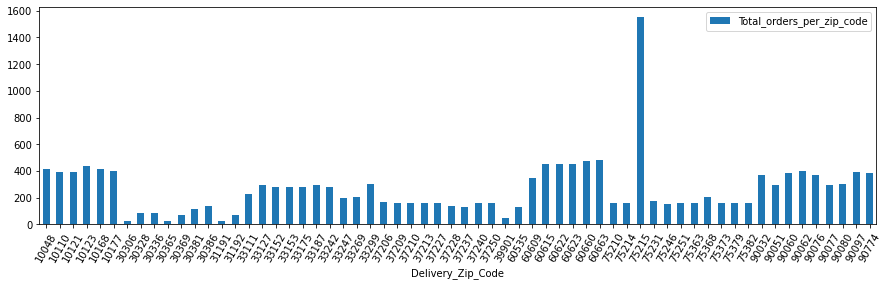

In [14]:
ax1 = df.groupby(['Delivery_Zip_Code'])['Expected_Delivery_Date'].count().reset_index(name ='Total_orders_per_zip_code').plot.bar(x='Delivery_Zip_Code', y='Total_orders_per_zip_code', rot=60, figsize=(15, 4))


In [15]:
Categories = df['Category'].unique()
Categories

array(['fitness', 'phone', 'speaker', 'tv', 'vr'], dtype=object)

In [16]:
Zips = df['Delivery_Zip_Code'].unique()
Zips

array([10048, 10110, 10121, 10123, 10168, 10177, 30306, 30328, 30336,
       30365, 30369, 30381, 30386, 31191, 31192, 33111, 33127, 33152,
       33153, 33175, 33187, 33242, 33247, 33269, 33299, 37206, 37209,
       37210, 37213, 37227, 37228, 37237, 37240, 37250, 39901, 60609,
       60535, 60615, 60622, 60623, 60660, 60663, 75210, 75214, 75215,
       75231, 75246, 75251, 75363, 75368, 75373, 75379, 75382, 90032,
       90051, 90060, 90062, 90076, 90077, 90080, 90097, 90774])

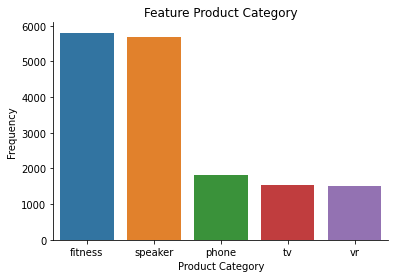

In [17]:
sort_X1 = df.groupby('Category').size()\
                    .sort_values(ascending=False)\
                    .index
#plt.figure(figsize=(12,6))
sns.countplot(x='Category', data=df, order = sort_X1)
plt.xlabel('Product Category')
plt.ylabel('Frequency')
plt.title('Feature Product Category')
sns.despine();

In [18]:
df_bx = pd.DataFrame({'count' : df.groupby( [ "Category", "Delivery_Zip_Code"] ).size()}).reset_index()

df_bx[1:303]

,Category,Delivery_Zip_Code,count
1,fitness,10110,139
2,fitness,10121,137
3,fitness,10123,154
4,fitness,10168,147
5,fitness,10177,148
...,...,...,...
298,vr,90060,38
299,vr,90062,41
300,vr,90076,40
301,vr,90077,27


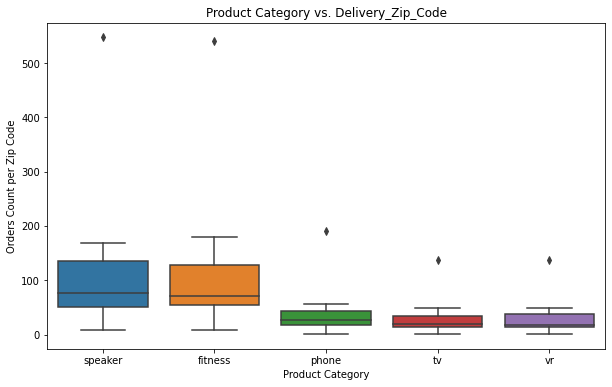

In [19]:
sort_y = df_bx.groupby('Category')['count']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
plt.figure(figsize = (10, 6))

sns.boxplot(y='count', x='Category', data=df_bx, order=sort_y)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels())
plt.xlabel('Product Category')
plt.ylabel('Orders Count per Zip Code')
plt.title('Product Category vs. Delivery_Zip_Code')
plt.show();

# Time Series Forecasting

- Calculate Total number of orders per Date

In [20]:
slice_for_zip_code = df.loc[df['Delivery_Zip_Code'] == 60535]

In [21]:
df_deliveries_count = slice_for_zip_code.groupby(['Expected_Delivery_Date'])['Order_ID'].count().reset_index(name ='Total_Number_of_orders')
df_deliveries_count

,Expected_Delivery_Date,Total_Number_of_orders
0,2018-01-10,1
1,2018-01-16,1
2,2018-01-18,2
3,2018-01-31,1
4,2018-02-05,1
...,...,...
107,2020-11-11,1
108,2020-11-18,1
109,2020-11-26,1
110,2020-11-29,1


## Distribution of Products Bought in Zip Codes

- Create 6-months bins

In [22]:
bins_dt = pd.date_range('2018-01-01', freq='6MS', periods=8)
bins_str = bins_dt.astype(str).values

labels = ['(2018-01-01, 2018-06-31)',
          '(2018-07-01, 2018-12-31)',
          '(2019-01-01, 2019-06-31)',
          '(2019-07-01, 2019-12-31)',
          '(2020-01-01, 2020-06-31)',
          '(2020-07-01, 2020-12-31)',
          '(2021-01-01, 2021-06-31)']
df_6_months_bins = df.groupby(['Expected_Delivery_Date'
                   ,'Product_Name'
                   ,'Delivery_Zip_Code'])['Order_ID'].count().reset_index(name ='Total_Number_of_orders')

df_6_months_bins['bins'] = pd.cut(df_6_months_bins['Expected_Delivery_Date'].astype(np.int64)//10**9,
                   bins=bins_dt.astype(np.int64)//10**9,
                   labels=labels)

In [23]:
df_6_months_bins

,Expected_Delivery_Date,Product_Name,Delivery_Zip_Code,Total_Number_of_orders,bins
0,2018-01-05,Logitech,33242,2,"(2018-01-01, 2018-06-31)"
1,2018-01-05,Logitech,60622,1,"(2018-01-01, 2018-06-31)"
2,2018-01-05,Logitech,75215,1,"(2018-01-01, 2018-06-31)"
3,2018-01-05,Logitech,90062,1,"(2018-01-01, 2018-06-31)"
4,2018-01-05,Redmi,37210,1,"(2018-01-01, 2018-06-31)"
...,...,...,...,...,...
12102,2021-01-04,Samsung s10,10123,1,"(2021-01-01, 2021-06-31)"
12103,2021-01-04,Samsung s10,33127,1,"(2021-01-01, 2021-06-31)"
12104,2021-01-04,Samsung s10,75210,1,"(2021-01-01, 2021-06-31)"
12105,2021-01-04,Samsung s10,75214,1,"(2021-01-01, 2021-06-31)"


In [24]:
grouped_bin_df = df_6_months_bins.groupby(['bins','Product_Name','Delivery_Zip_Code'])['Total_Number_of_orders'].sum().reset_index(name ='Total_Number_of_orders')
grouped_bin_df['Total_Number_of_orders'] = grouped_bin_df['Total_Number_of_orders'].fillna(0)
grouped_bin_df.head(10)

,bins,Product_Name,Delivery_Zip_Code,Total_Number_of_orders
0,"(2018-01-01, 2018-06-31)",Bose,10048,2
1,"(2018-01-01, 2018-06-31)",Bose,10110,2
2,"(2018-01-01, 2018-06-31)",Bose,10121,1
3,"(2018-01-01, 2018-06-31)",Bose,10123,2
4,"(2018-01-01, 2018-06-31)",Bose,10168,4
5,"(2018-01-01, 2018-06-31)",Bose,10177,0
6,"(2018-01-01, 2018-06-31)",Bose,30306,0
7,"(2018-01-01, 2018-06-31)",Bose,30328,0
8,"(2018-01-01, 2018-06-31)",Bose,30336,2
9,"(2018-01-01, 2018-06-31)",Bose,30365,0


## Lets filter total orders for specific list of Zip Codes

- List of Zip Codes: [60623, 60663, 60609, 60660, 60615, 60622]

In [25]:
zip_codes = [60623, 60663, 60609, 60660, 60615, 60622]
grouped_bin_df = grouped_bin_df[grouped_bin_df.Delivery_Zip_Code.isin(zip_codes)]
grouped_bin_df

,bins,Product_Name,Delivery_Zip_Code,Total_Number_of_orders
36,"(2018-01-01, 2018-06-31)",Bose,60609,6
37,"(2018-01-01, 2018-06-31)",Bose,60615,2
38,"(2018-01-01, 2018-06-31)",Bose,60622,8
39,"(2018-01-01, 2018-06-31)",Bose,60623,3
40,"(2018-01-01, 2018-06-31)",Bose,60660,7
...,...,...,...,...
4315,"(2021-01-01, 2021-06-31)",VR7,60615,0
4316,"(2021-01-01, 2021-06-31)",VR7,60622,0
4317,"(2021-01-01, 2021-06-31)",VR7,60623,0
4318,"(2021-01-01, 2021-06-31)",VR7,60660,0


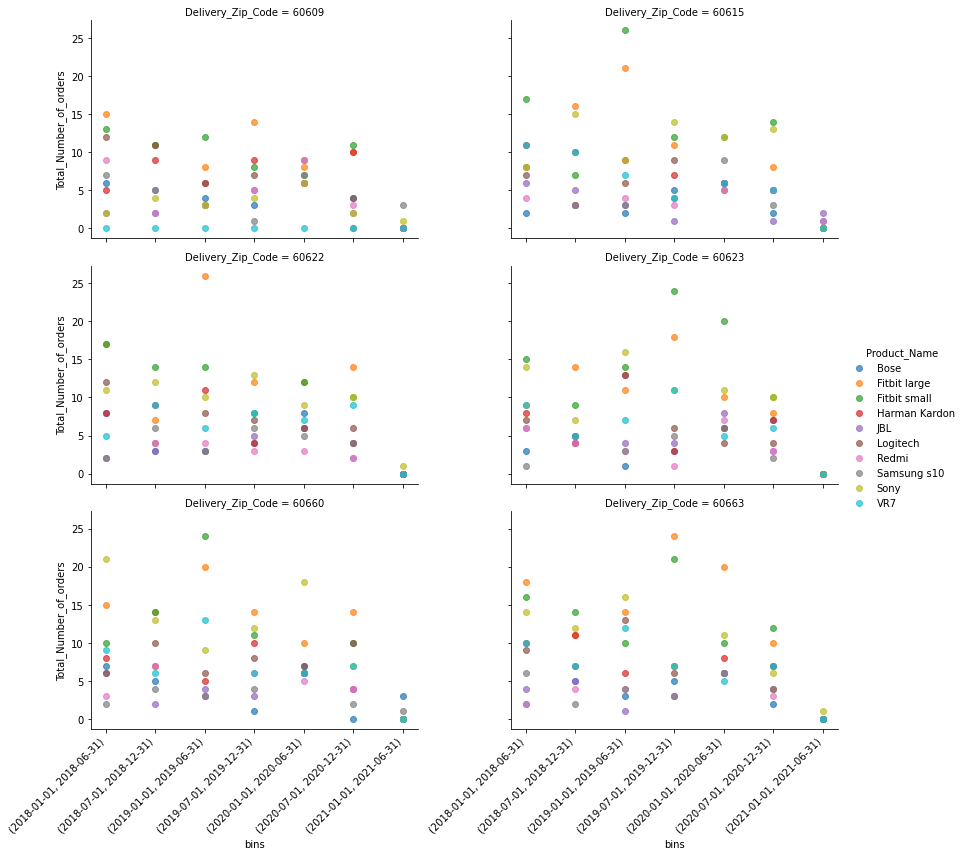

In [26]:
g = sns.FacetGrid(grouped_bin_df, col="Delivery_Zip_Code", hue="Product_Name", margin_titles=True, col_wrap=2, height=4, aspect=1.5)
g.map(plt.scatter, 'bins', 'Total_Number_of_orders', alpha=.7)
ha = ['right', 'center', 'left']
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha=ha[0])
plt.tight_layout(h_pad=1)
g.add_legend();

## Total number of Orders per Month
- for selected Zip Codes: [60623, 60663, 60609, 60660, 60615, 60622]

In [27]:
monthly_df = df.groupby(['month',
                         'Delivery_Zip_Code'])['OrderID'].count().reset_index(name ='Total_Number_of_orders_per_month')
monthly_df = monthly_df[monthly_df.Delivery_Zip_Code.isin(zip_codes)]
monthly_df

,month,Delivery_Zip_Code,Total_Number_of_orders_per_month
36,1,60609,45
37,1,60615,59
38,1,60622,54
39,1,60623,68
40,1,60660,66
...,...,...,...
714,12,60615,39
715,12,60622,36
716,12,60623,32
717,12,60660,41


In [28]:
monthly_df_products = df.groupby(['month',
                         'Product_Name',
                         'Delivery_Zip_Code'])['OrderID'].count().reset_index(name ='Total_Number_of_orders_per_month')
monthly_df_products = monthly_df_products[monthly_df_products.Delivery_Zip_Code.isin(zip_codes)]
monthly_df_products

,month,Product_Name,Delivery_Zip_Code,Total_Number_of_orders_per_month
21,1,Bose,60609,4
22,1,Bose,60615,4
23,1,Bose,60622,4
24,1,Bose,60623,2
25,1,Bose,60660,6
...,...,...,...,...
4973,12,VR7,60615,2
4974,12,VR7,60622,4
4975,12,VR7,60623,4
4976,12,VR7,60660,2


## Total number of Orders  per Zip Code per Month
- for selected Zip Codes: [60623, 60663, 60609, 60660, 60615, 60622]

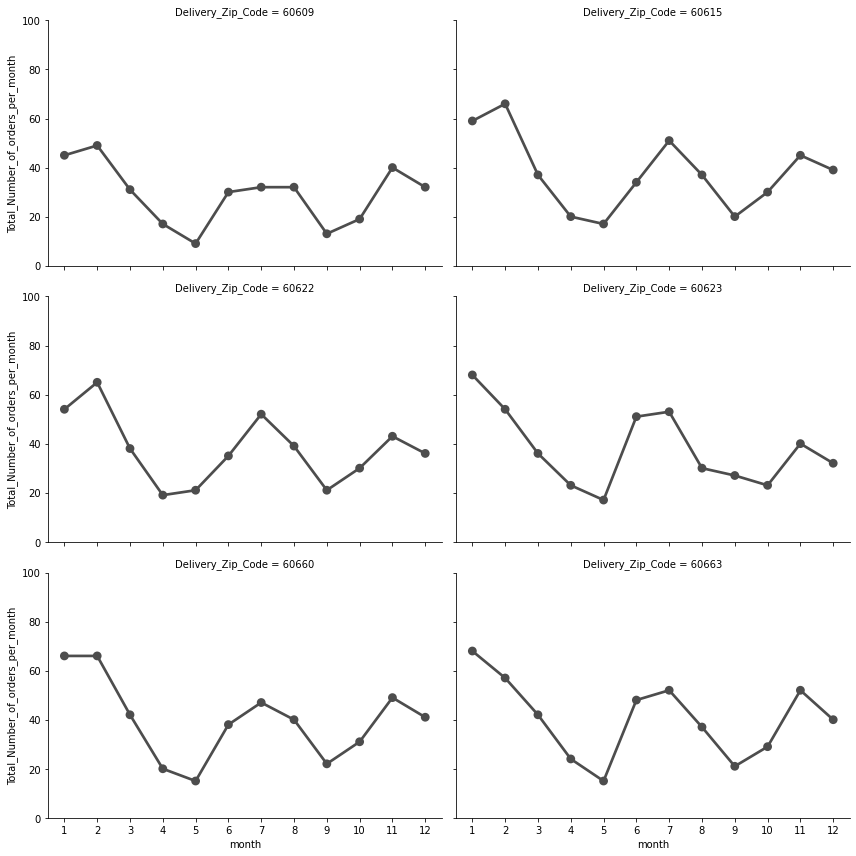

In [29]:
g = sns.FacetGrid(monthly_df, col="Delivery_Zip_Code", col_wrap=2,  ylim=(0, 100), height=4, aspect=1.5)
g.map(sns.pointplot, "month", "Total_Number_of_orders_per_month", color=".3", ci=None);

## Total Number of Orders per Product per Zip Code per Month:
- for selected Zip Codes: [60623, 60663, 60609, 60660, 60615, 60622]

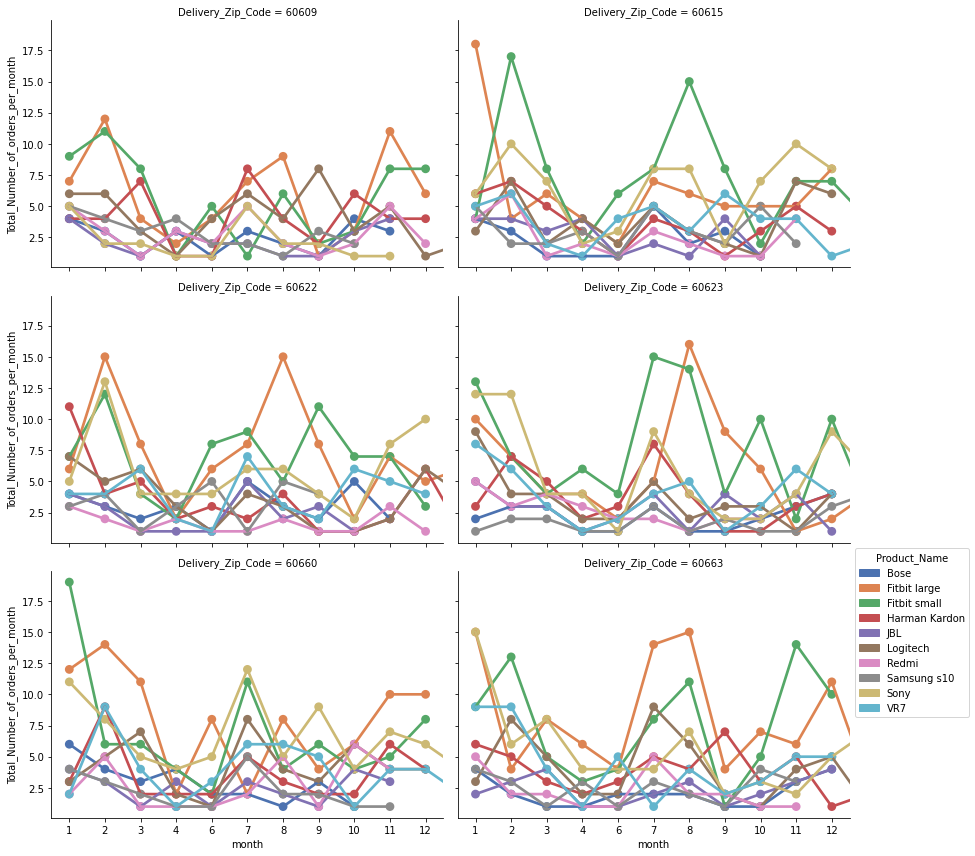

In [30]:
from matplotlib import patches
g = sns.FacetGrid(monthly_df_products, col="Delivery_Zip_Code", 
                  hue="Product_Name",
                  margin_titles=True, 
                  col_wrap=2, palette="deep", 
                  height=4, aspect=1.5)

g.map(sns.pointplot, "month", "Total_Number_of_orders_per_month", ci=None)  # 
labels = ["Bose","Fitbit large","Fitbit small","Harman Kardon","JBL","Logitech","Redmi","Samsung s10","Sony","VR7"] #hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col,label=lab) for col,lab in zip(colors,labels)]
plt.legend(handles=handles,title='Product_Name',loc='center left',bbox_to_anchor=(1,0.75));

In [31]:
fig = px.line(df_deliveries_count, x='Expected_Delivery_Date', y='Total_Number_of_orders')
fig.update_layout(title_text='Time Series of daily order counts for all users for zip code: 60535')
fig.show()

# Experiment #1

## Prophet Timeseries Forecasting

### Forecasting orders for zip code: 60535

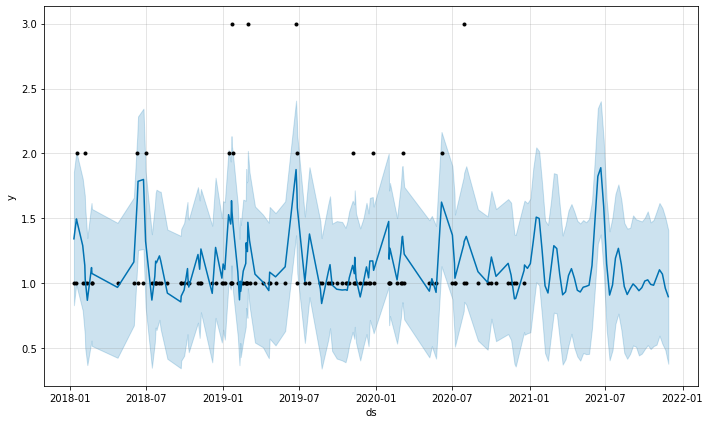

In [32]:
df_deliveries_count = df_deliveries_count.rename(columns = {'Expected_Delivery_Date': 'ds',
                                'Total_Number_of_orders': 'y'})
 
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_deliveries_count) 
future_dates = model.make_future_dataframe(periods = 50, freq='W')
forecast = model.predict(future_dates)

model.plot(forecast);

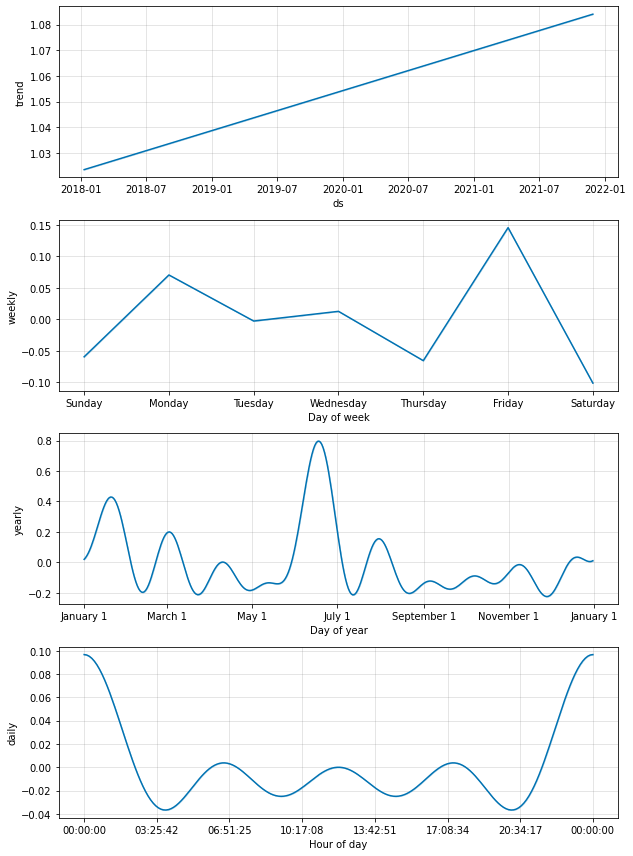

In [33]:
model.plot_components(forecast);

<div class="alert alert-warning">

    
Prediction info:
**Hoover the mouse over the chart to see data and predicted values**

    

</div>

In [34]:
plot_plotly(model, forecast)

In [35]:
plot_components_plotly(model, forecast)

### Forecasting orders for all zip codes:

In [36]:
df_deliveries_allzip = df.groupby(['Expected_Delivery_Date'])['Order_ID'].count().reset_index(name ='Total_Number_of_orders')
df_deliveries_allzip = df_deliveries_allzip.rename(columns = {'Expected_Delivery_Date': 'ds',
                                'Total_Number_of_orders': 'y'})
 
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_deliveries_allzip) 
future_dates = model.make_future_dataframe(periods = 50, freq='W')
forecast = model.predict(future_dates)

plot_plotly(model, forecast)

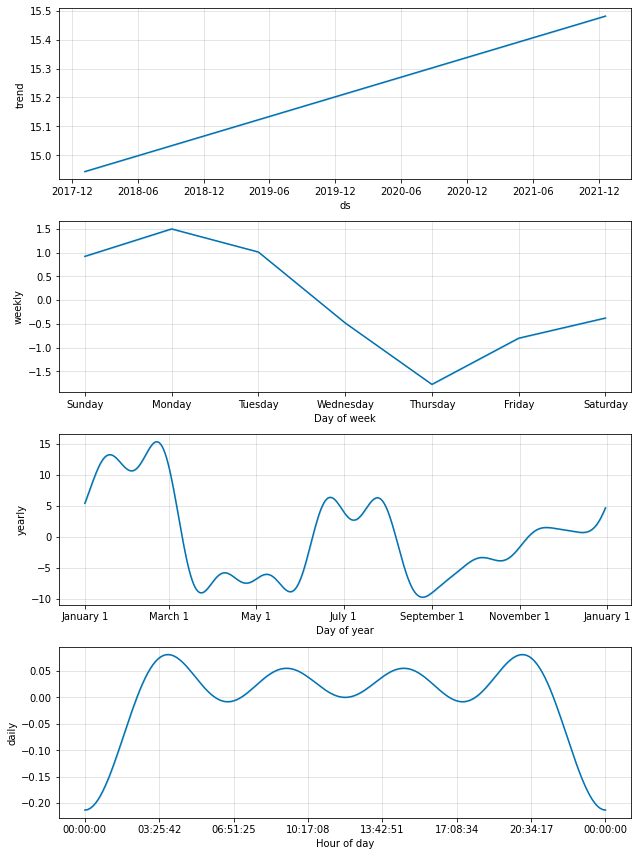

In [37]:
model.plot_components(forecast);

# Experiment #2

## StatModel Timeseries Forecasting

### Forecasting orders for zip code: 60535

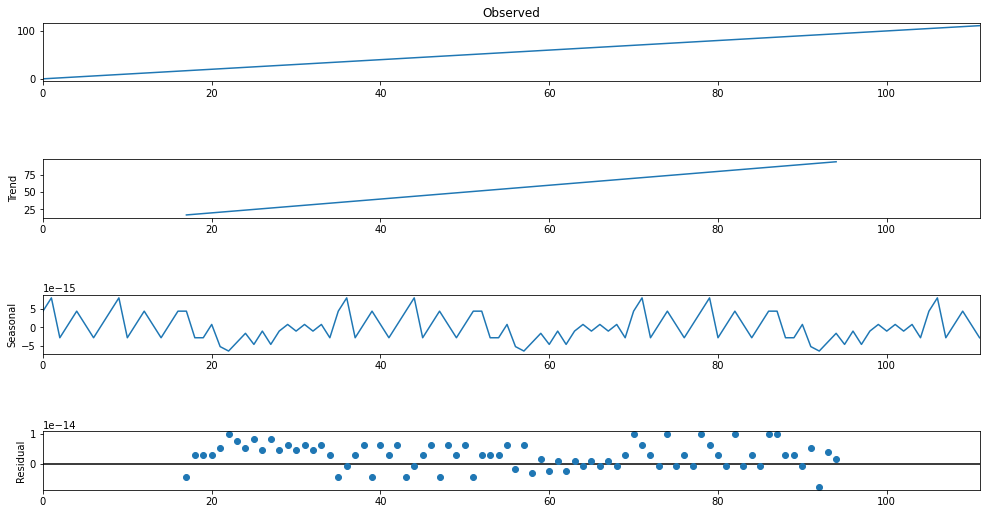

In [48]:
# Model to forecast orders for zip code = 60535
df_deliveries_count.set_index('ds')
predict = sm.tsa.seasonal_decompose(df_deliveries_count.index, period=35)
figure = predict.plot()
figure.set_size_inches(15, 8)

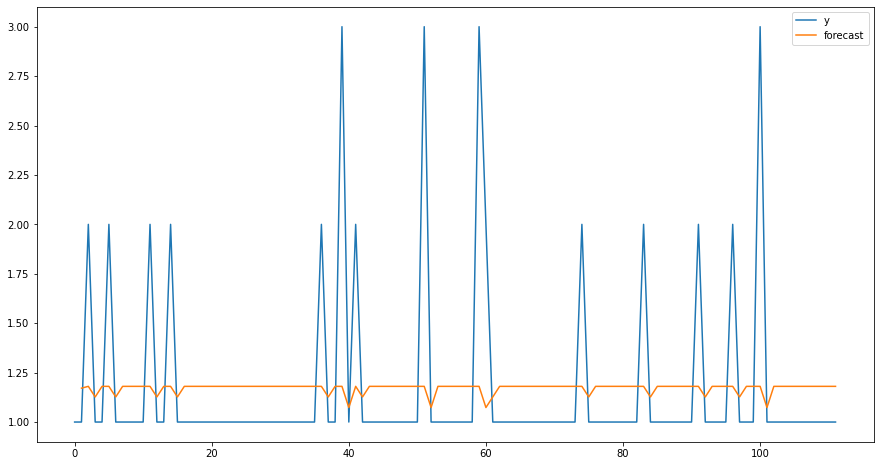

In [49]:
df_stats_model = df_deliveries_count
model = sm.tsa.ARIMA(df_stats_model['y'].iloc[1:], order = (1,0,0))
results = model.fit()
df_stats_model['forecast'] = results.fittedvalues
df_stats_model[['y', 'forecast']].plot(figsize=(15,8))

Since the evaluation is not consistant with the actual data, fine tuning the hyperparameters (p, d, q) of ARIMA model will yield a better result. We now proceed to plot the ACF and PACF plots. A quick reading of this documents will help in interpreating the graphs: 
 
- http://people.duke.edu/~rnau/411arim3.htm
- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

Check the ACF graph:

*   ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information. We determine p using the ACF graph

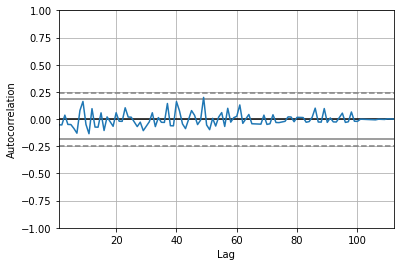

In [50]:
df_deliveries_series = pd.Series(df_deliveries_count['y'].values, index=df_deliveries_count['ds'])
pd.plotting.autocorrelation_plot(pd.Series(df_deliveries_series))
plt.show()

It can be seen that there is one significant value so p = 1 

 Check the PACF graph:

*    PACF only describes the direct relationship between an observation and its lag. We determine q from this graph. 



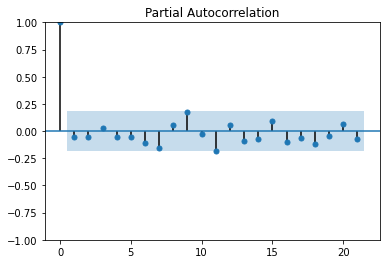

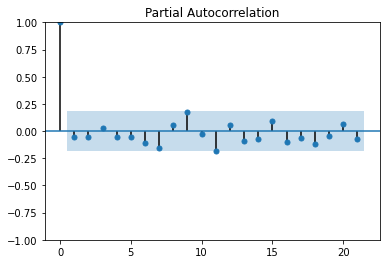

In [51]:
plot_pacf(df_deliveries_series)

 It can be seen that there is one significant value so q = 1 

Check the d value: 

In [52]:
ndiffs(df_deliveries_series, test='adf')

0

It can be seen that d = 0 

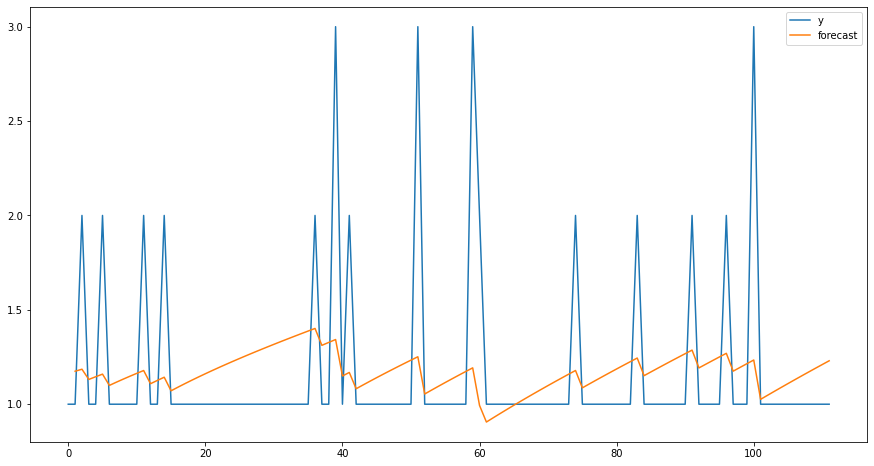

In [53]:
df_stats_model = df_deliveries_count
model = sm.tsa.ARIMA(df_stats_model['y'].iloc[1:], order = (1,0,1))
results = model.fit()
df_stats_model['forecast'] = results.fittedvalues
df_stats_model[['y', 'forecast']].plot(figsize=(15,8))

### Forecasting orders from the above data with x labels as dates:

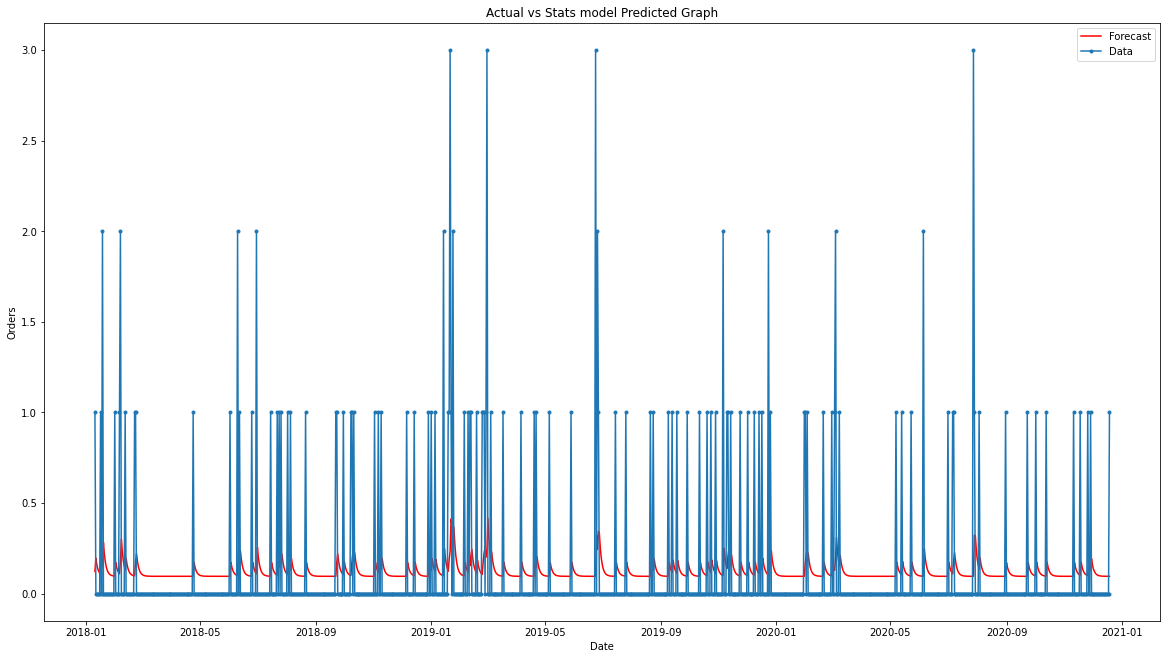

In [54]:
lzip = lambda *x:list(zip(*x))

days = df_deliveries_count.groupby('ds')['ds'].value_counts()
Y = df_deliveries_count['y'].values
X = lzip(*days.index.values)[0]
firstDay = min(X)

# To achieve data consistancy with both actual data and predicted values, I'm adding zeros to dates that do not have orders 
Ys = [0,]*((max(X) - firstDay).days + 1)#[firstDay + timedelta(days=day) for day in range((max(X) - firstDay).days + 1)]
days = pd.Series([firstDay + timedelta(days=i) for i in range(len(Ys))])
for x, y in zip(X, Y):
    Ys[(x - firstDay).days] = y
# parameters of the stats model is based on the below two graphs
est = sm.tsa.ARIMA(Ys, order=(1,0,1)).fit()
yHat = est.fittedvalues
 
fig, axs = plt.subplots(1, 1, figsize=(20, 11))
X = mdates.date2num(days)
axs.plot(X, yHat, c='red', label='Forecast')
axs.plot(X, Ys, marker='.', label='Data')
locator = mdates.AutoDateLocator()
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
axs.legend()
axs.set_title('Actual vs Stats model Predicted Graph')
axs.set_xlabel('Date')
axs.set_ylabel('Orders')
plt.show()

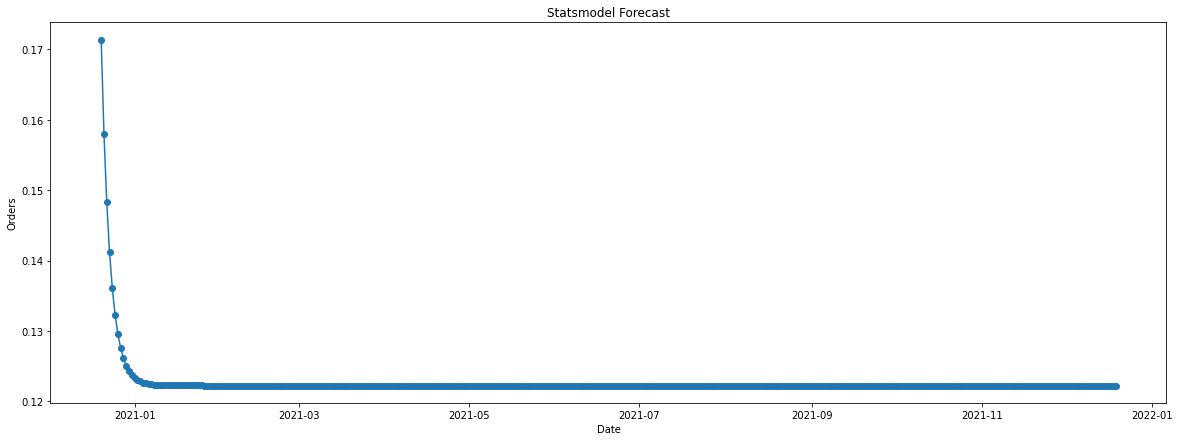

In [56]:
# Plotting the forecast:
lastDay = max(df_deliveries_count['ds'])
X = [lastDay + timedelta(days=i) for i in range(1, 365 + 1)]
weekday = pd.Series([x.weekday() for x in X])
X = mdates.date2num(X)
# Predict orders for future dates:
pred_fd = est.forecast(steps=365)
Y = pred_fd

fig, axs = plt.subplots(1, 1, figsize=(20, 7))
axs.plot(X, Y, marker='o', label='Forecast')
locator = mdates.AutoDateLocator()
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
axs.set_title('Statsmodel Forecast')
axs.set_xlabel('Date')
axs.set_ylabel('Orders')
plt.show()

# Experiment #3


## LSTMs using TensorFlow 2 and Keras

### Forecasting orders for all zip codes.

In [57]:
# Creating data for all zip codes
lzip = lambda *x:list(zip(*x))

days = df_deliveries_allzip.groupby('ds')['ds'].value_counts()
Y = df_deliveries_allzip['y'].values
X = lzip(*days.index.values)[0]
firstDay = min(X)

# To achieve data consistancy with both actual data and predicted values, I'm adding zeros to dates that do not have orders 
Ys = [0,]*((max(X) - firstDay).days + 1)#[firstDay + timedelta(days=day) for day in range((max(X) - firstDay).days + 1)]
days = pd.Series([firstDay + timedelta(days=i) for i in range(len(Ys))])
for x, y in zip(X, Y):
    Ys[(x - firstDay).days] = y

In [58]:
# modify the data that is suitable for LSTM
Ys = np.array(Ys)
Ys = Ys.astype('float32')
Ys = np.reshape(Ys, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
Ys = scaler.fit_transform(Ys)
train_size = int(len(Ys) * 0.80)
test_size = len(Ys) - train_size
train, test = Ys[0:train_size,:], Ys[train_size:len(Ys),:]
print('train size:',len(train),", test size:",len(test))

train size: 876 , test size: 220


In [59]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [60]:
# Look back decides how many days of data the model looks at for prediction
look_back = 30 # Here LSTM looks at approximately one month data
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# verifying the shapes
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((845, 1, 30), (189, 1, 30), (845,), (189,))

In [61]:
# # Model to forecast orders for all zip code
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
13/13 [==============================] - 7s 237ms/step - loss: 0.0442 - val_loss: 0.0261
Epoch 2/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0311 - val_loss: 0.0262
Epoch 3/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0289 - val_loss: 0.0252
Epoch 4/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0289 - val_loss: 0.0246
Epoch 5/20
13/13 [==============================] - 0s 19ms/step - loss: 0.0271 - val_loss: 0.0243
Epoch 6/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0265 - val_loss: 0.0240
Epoch 7/20
13/13 [==============================] - 0s 19ms/step - loss: 0.0258 - val_loss: 0.0237
Epoch 8/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0263 - val_loss: 0.0235
Epoch 9/20
13/13 [==============================] - 0s 16ms/step - loss: 0.0252 - val_loss: 0.0233
Epoch 10/20
13/13 [==============================] - 0s 15ms/step - loss: 0.0254 - val_loss: 0.0231
Epoch 11

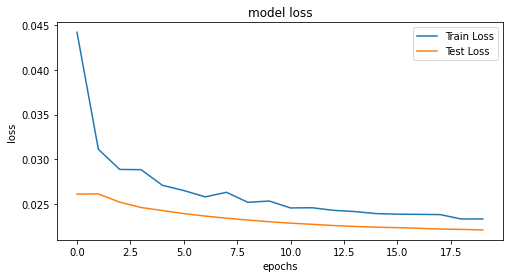

In [62]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [63]:
# predict orders for test data
y_pred = model.predict(X_test)

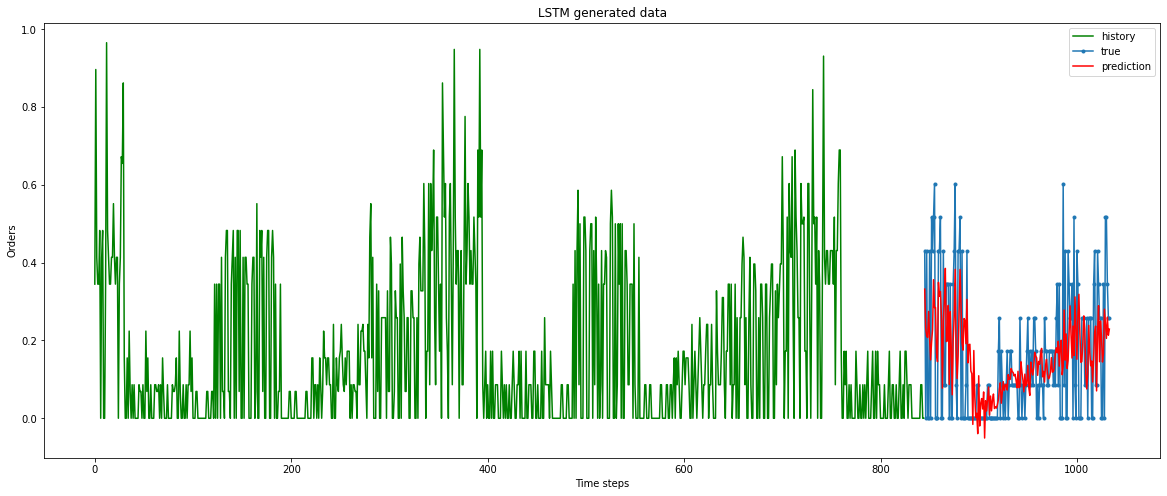

In [64]:
fig, axs = plt.subplots(1, 1, figsize=(20, 8))
X = mdates.date2num(days)
axs.plot(np.arange(0, len(Y_train)), Y_train, 'g', label="history")
axs.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Y_test, marker='.', label="true")
axs.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), y_pred, 'r', label="prediction")
axs.legend()
axs.set_title('LSTM generated data')
axs.set_xlabel('Time steps')
axs.set_ylabel('Orders')
plt.show()

### Forecasting orders from the above data with x labels as dates:

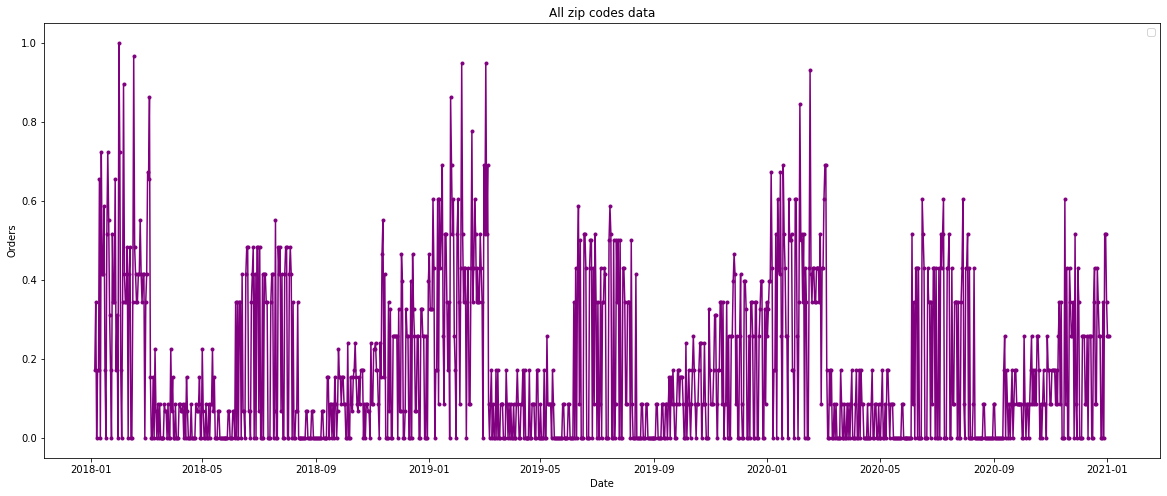

In [65]:
fig, axs = plt.subplots(1, 1, figsize=(20, 8))
X = mdates.date2num(days)
axs.plot(X, Ys, 'purple', marker='.')
locator = mdates.AutoDateLocator()
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
axs.legend()
axs.set_title('All zip codes data')
axs.set_xlabel('Date')
axs.set_ylabel('Orders')
plt.show()

 The above two graphs look different. In the graph named LSTM generated data we are missing a few datapoints, this is because of the look back feature of the LSTM model. The cell containing the method called create_dataset we have the expression:

for i in range(len(dataset)-look_back-1):

due to which we loose some datapoints. In the below cell the plot named (Actual data vs predicted data) contains all the datapoints from the begining date until the point where prediction is plotted (actual data is displayed instead of Y_train) whereas Y_test is used as it is.


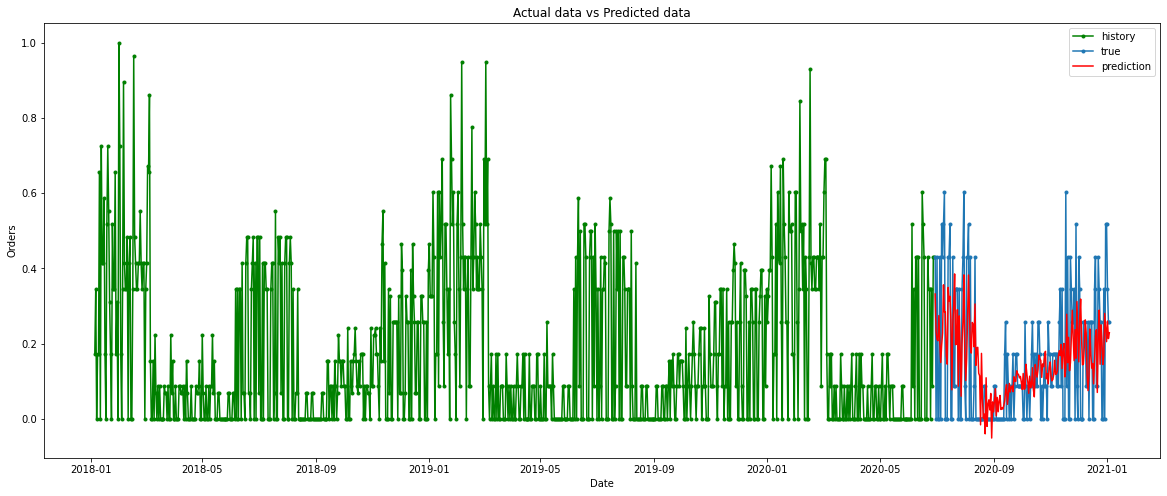

In [66]:
fig, axs = plt.subplots(1, 1, figsize=(20, 8))
X = mdates.date2num(days)
axs.plot(X[:907], Ys[:907], marker='.', color = 'g', label="history")
axs.plot(X[907:], Y_test, marker='.', label="true")
axs.plot(X[907:], y_pred, 'r', label="prediction")
locator = mdates.AutoDateLocator()
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
axs.legend()
axs.set_title('Actual data vs Predicted data')
axs.set_xlabel('Date')
axs.set_ylabel('Orders')
plt.show()